<a href="https://colab.research.google.com/github/Doppler-67/taxi-orders-forecasting/blob/main/taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sns.set()

In [3]:
np.random.seed(67)

#**Data understanding**

In [4]:
data = pd.read_csv('/content/drive/MyDrive/taxi_orders_forecasting/taxi.csv')

In [5]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


#**Data preparation**

Для начала приведем колонку datetime к нужному типу и сделаем ее индексом.

In [8]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [9]:
data = data.set_index('datetime').sort_index()

Выполним ресемплирование, чтобы временной промежуток между строками равнялся одному часу.

In [10]:
data = data.resample('1H').sum()

Посмотрим на предобработанные данные.

In [11]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


#**EDA**

Визуализируем данные и изучим тренд.

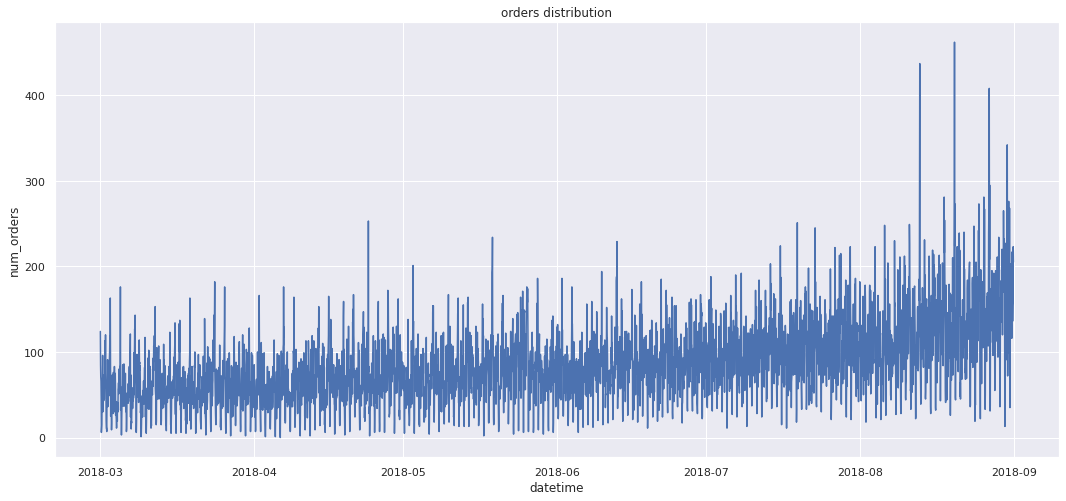

In [12]:
plt.figure(figsize=(18, 8))

sns.lineplot(x=data.index, y=data['num_orders'])
plt.title('orders distribution')

plt.show()

In [13]:
decomposed = seasonal_decompose(data['num_orders'])

По графику тренда видно, что спрос на такси планомерно возрастает.

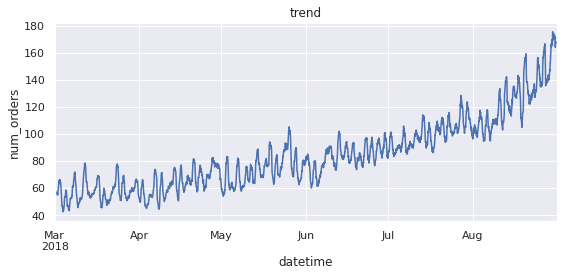

In [14]:
plt.figure(figsize=(8, 4))
decomposed.trend.plot(ax=plt.gca())
plt.title('trend')
plt.ylabel('num_orders')
plt.tight_layout()

# **Feature engeneering**

Реализуем добавление новых признаков с помощью фукнции.

In [15]:
def add_features(data, amount_of_lags=1, amount_of_sma=6, rolling_window=4, rolling_step=3):
    modified_data = data.copy()
    modified_data['day'] = data.index.day
    modified_data['day_of_week'] = data.index.dayofweek
    
    for i in range(1, amount_of_lags+1):
        modified_data['lag_{}'.format(i)] = modified_data['num_orders'].shift(i)
        

    for i in range(amount_of_sma):
          col_name = 'moving_average_{}'.format(rolling_window+rolling_step*i)
          modified_data[col_name] = modified_data['num_orders'].shift().rolling(rolling_window+rolling_step*i).mean()
    
    modified_data = modified_data.dropna()
    
    return modified_data
    

In [16]:
modified_data = add_features(data, 25, 5, 3, 3)

In [17]:
modified_data.head()

,num_orders,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_21,lag_22,lag_23,lag_24,lag_25,moving_average_3,moving_average_6,moving_average_9,moving_average_12,moving_average_15
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 01:00:00,120,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,43.0,66.0,71.0,85.0,124.0,87.000000,72.166667,65.888889,61.583333,61.933333
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,6.0,43.0,66.0,71.0,85.0,89.333333,84.666667,74.444444,68.916667,65.666667
2018-03-02 03:00:00,64,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,12.0,6.0,43.0,66.0,71.0,95.000000,87.000000,77.888889,71.166667,64.266667
2018-03-02 04:00:00,20,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,15.0,12.0,6.0,43.0,66.0,86.333333,86.666667,76.888889,71.000000,66.533333
2018-03-02 05:00:00,11,2,4,20.0,64.0,75.0,120.0,90.0,58.0,113.0,...,34.0,15.0,12.0,6.0,43.0,53.000000,71.166667,74.111111,69.083333,65.733333


# **Modeling**

In [18]:
x = modified_data.drop('num_orders', axis=1)
y = modified_data['num_orders']

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, train_size=0.8)

In [19]:
tscv = TimeSeriesSplit(n_splits=5)

В качестве моделей возьмем линейную регрессию, случайный лес и xgboost. Подберем параметры к моделям и выберем лучшую при помощи кросс-валидации в 5 фолдов.

In [20]:
model = LinearRegression()
scores = cross_val_score(model, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
print('avg rmse:', -round(sum(scores) / len(scores), 2))

avg rmse: 26.1


In [21]:
model = RandomForestRegressor(random_state=67)
scores = cross_val_score(model, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
print('avg rmse:', -round(sum(scores) / len(scores), 2))

avg rmse: 24.43


In [22]:
model = XGBRegressor(random_state=67, objective='reg:squarederror')
scores = cross_val_score(model, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
print('avg rmse:', -round(sum(scores) / len(scores), 2))

avg rmse: 24.49


В базовой версии лучше всех справился случайный лес. Теперь переберем гиперпараметры.

In [23]:
random_forest_params = {'max_depth': np.arange(3, 13, 1),
                        'n_estimators': np.arange(100, 1001, 25),
                        'min_samples_leaf': np.arange(1, 5),
                        'min_samples_split': np.arange(2, 11)
                        }

In [24]:
model = RandomForestRegressor(random_state=67)
clf = RandomizedSearchCV(model, random_forest_params, cv=tscv, random_state=67)
clf.fit(x_train, y_train)

scores = cross_val_score(clf.best_estimator_, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
print('avg rmse:', -round(sum(scores) / len(scores), 2))

avg rmse: 24.29


In [25]:
xgb_params = {
              'learning_rate': np.arange(0.05, 0.31, 0.05),
              'max_depth': np.arange(3, 13, 1, dtype=int),
              'min_child_weight': np.arange(1, 8, 1, dtype=int),
              'colsample_bytree': np.arange(0.3, 0.8, 0.1),
              'n_estimators': np.arange(100, 1001, 25, dtype=int)
             }

In [26]:
model = XGBRegressor(objective='reg:squarederror', random_state=67)
clf = RandomizedSearchCV(model, xgb_params, cv=tscv, random_state=67)
clf.fit(x_train, y_train)

scores = cross_val_score(clf.best_estimator_, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
print('avg rmse:', -round(sum(scores) / len(scores), 2))

avg rmse: 24.18


Лучше всех себя показал xgboost. Возьмем его в качестве основной модели.

# **Testing**

Перед тем как проверить нашу модель на тестовой выборке, протестируем несколько наивных методов предсказания временных рядов и сравним потом их результаты с результатом модели.

В качестве первого метода просто заполним предсказания медианой и посчитаем RMSE. 

In [27]:
pred_median  = np.ones(y_test.shape) * y_test.median()
mean_squared_error(y_test, pred_median, squared=False)

54.803226448120775

В качестве второго метода заполним предсказания предыдущим значением ряда.

In [28]:
pred_last = y_test.shift(fill_value=y_train[-1])
mean_squared_error(y_test, pred_last, squared=False)

53.431859363064575

А теперь протестируем нашу модель.

In [29]:
y_predicted = clf.best_estimator_.predict(x_test)
mean_squared_error(y_test, y_predicted, squared=False)

41.61331940753003

Как мы видим, у нашей модели RMSE меньше, чем у наивных моделей, а значит проверка на адекватность пройдена.

# **Results**

Отобразим реальный ряд и ряд, котороый предсказала наша модель.

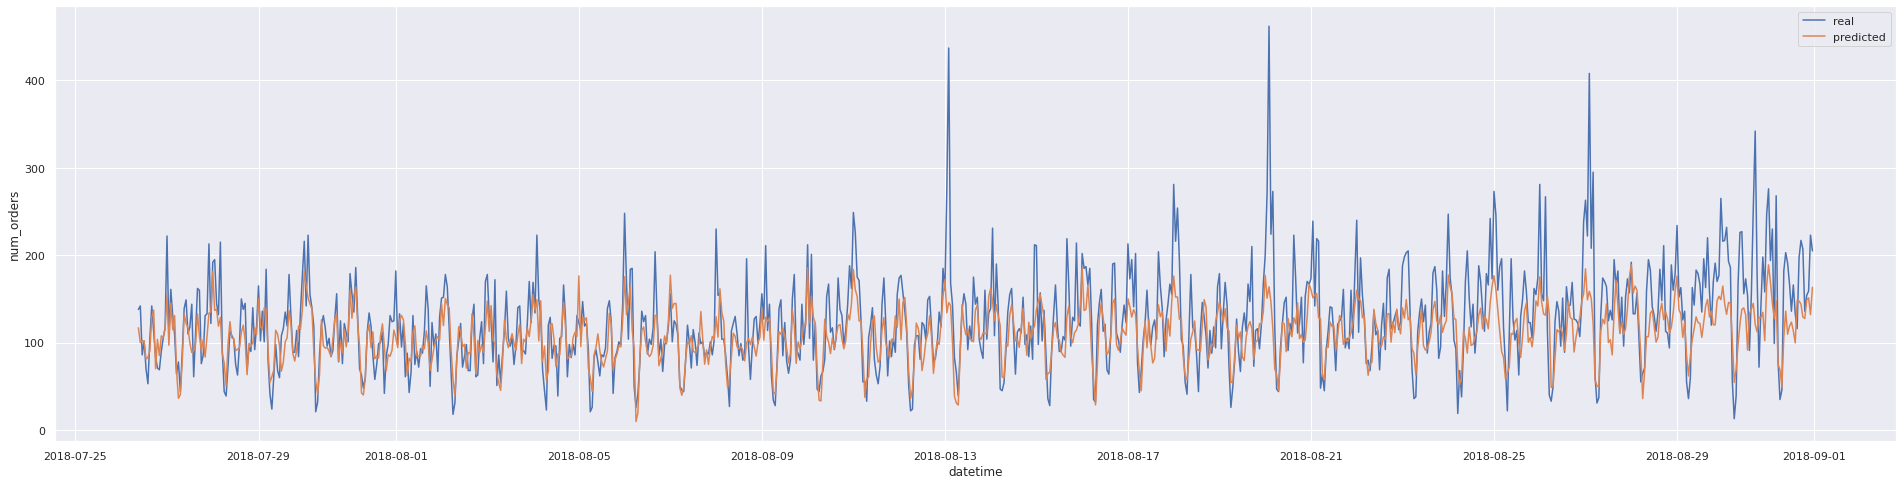

In [30]:
plt.figure(figsize=(33, 8))

sns.lineplot(x=y_test.index, y=y_test, label= 'real')
sns.lineplot(x=y_test.index, y=y_predicted, label='predicted')
plt.legend()

plt.show()

Как мы видим, модель ошибается на резких пиках, в остальном она довольно точна.

**В итоге лучшей моделью оказалась модель xgboost. Была написана функция для удобного добавления новых признаков. Было протестировано несколько моделей и к ним были подобраны параметры. Лучшая модель прошла проверку на адекватность и ей удалось достичь 41.6 RMSE на тестовой выборке.**